# Text Classification using Scikit-Learn

## 1. Load the dataset (with sentiment)

In [1]:
import pandas as pd

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
df = pd.read_pickle('movie_reviews_with_sentiment.pkl')
df.head(2)

,movie_title,rating,genre,in_theaters_date,movie_info,directors,director_gender,tomatometer_rating,audience_rating,critics_consensus,sentiment
0,A Dog's Journey,PG,"Drama, Kids & Family",5/17/19,"Bailey (voiced again by Josh Gad) is living the good life on the Michigan farm of his ""boy,"" Ethan (Dennis Quaid) and Ethan's wife Hannah (Marg Helgenberger). He even has a new playmate: Ethan and Hannah's baby granddaughter, CJ. The problem is that CJ's mom, Gloria (Betty Gilpin), decides to take CJ away. As Bailey's soul prepares to leave this life for a new one, he makes a promise to Ethan to find CJ and protect her at any cost. Thus begins Bailey's adventure through multiple lives filled with love, friendship and devotion as he, CJ (Kathryn Prescott), and CJ's best friend Trent (Henry Lau) experience joy and heartbreak, music and laughter, and few really good belly rubs.",Gail Mancuso,female,50,92,"A Dog's Journey is as sentimental as one might expect, but even cynical viewers may find their ability to resist shedding a tear stretched to the puppermost limit.",0.9837
1,A Dog's Way Home,PG,Drama,1/11/19,"Separated from her owner, a dog sets off on an 400-mile journey to get back to the safety and security of the place she calls home. Along the way, she meets a series of new friends and manages to bring a little bit of comfort and joy to their lives.",Charles Martin Smith,male,60,71,"A Dog's Way Home may not quite be a family-friendly animal drama fan's best friend, but this canine adventure is no less heartwarming for its familiarity.",0.9237


## 2. Clean & Normalize the data

In [4]:
import clean_and_normalize_text as cn

In [5]:
df['movie_info_clean'] = cn.clean_and_normalize(df.movie_info)
temp_df = df[['movie_title', 'movie_info', 'director_gender', 'sentiment', 'movie_info_clean']]
temp_df.head(2)

,movie_title,movie_info,director_gender,sentiment,movie_info_clean
0,A Dog's Journey,"Bailey (voiced again by Josh Gad) is living the good life on the Michigan farm of his ""boy,"" Ethan (Dennis Quaid) and Ethan's wife Hannah (Marg Helgenberger). He even has a new playmate: Ethan and Hannah's baby granddaughter, CJ. The problem is that CJ's mom, Gloria (Betty Gilpin), decides to take CJ away. As Bailey's soul prepares to leave this life for a new one, he makes a promise to Ethan to find CJ and protect her at any cost. Thus begins Bailey's adventure through multiple lives filled with love, friendship and devotion as he, CJ (Kathryn Prescott), and CJ's best friend Trent (Henry Lau) experience joy and heartbreak, music and laughter, and few really good belly rubs.",female,0.9837,bailey voice josh gad live good life michigan farm boy ethan dennis quaid ethans wife hannah marg helgenberger new playmate ethan hannah baby granddaughter cj problem cjs mom gloria betty gilpin decide cj away bailey soul prepare leave life new make promise ethan find cj protect cost begin bailey adventure multiple life fill love friendship devotion cj kathryn prescott cjs good friend trent henry lau experience joy heartbreak music laughter good belly rub
1,A Dog's Way Home,"Separated from her owner, a dog sets off on an 400-mile journey to get back to the safety and security of the place she calls home. Along the way, she meets a series of new friends and manages to bring a little bit of comfort and joy to their lives.",male,0.9237,separate owner dog set 400mile journey safety security place call home way meet series new friend manage bring little bit comfort joy life


## 3. CountVectorizer + Naive Bayes & Logistic Regression & Linear SVM

### 1. Import everything we need

In [10]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

### 2. Split the data into train & test (80% train, 20% test)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    df['movie_info_clean'], df['director_gender'], test_size=0.2, random_state=42, stratify=df['director_gender']
)
print('distribution of genders in training data: ', y_train.value_counts(normalize=True))
print('distribution of genders in testing data: ', y_test.value_counts(normalize=True))

distribution of genders in training data:  director_gender
male      0.810606
female    0.189394
Name: proportion, dtype: float64
distribution of genders in testing data:  director_gender
male      0.794118
female    0.205882
Name: proportion, dtype: float64


### 3. Define the 3 models we wanna train & test on + the hyperparams for CountVectorizer

In [33]:
models = {
    "Naive Bayes": (
        MultinomialNB(),
        {
            'vectorizer__ngram_range': [(1,1), (1,2)],
            'vectorizer__min_df': [0.01, 0.05, 0.1],
            'vectorizer__max_df': [0.8, 0.9, 1.0],
            'clf__alpha': [0.1, 1.0, 5.0, 10.0]
        }
    ),
    "Logistic Regression": (
        LogisticRegression(max_iter=500, solver='liblinear', class_weight='balanced'),
        {
            'vectorizer__ngram_range': [(1,1), (1,2)],
            'vectorizer__min_df': [0.01, 0.05, 0.1],
            'vectorizer__max_df': [0.8, 0.9, 1.0],
            'clf__C': [0.01, 0.1, 1, 10]
        }
    ),
    "Linear SVM": (
        LinearSVC(class_weight='balanced'),
        {
            'vectorizer__ngram_range': [(1,1), (1,2)],
            'vectorizer__min_df': [0.01, 0.05, 0.1],
            'vectorizer__max_df': [0.8, 0.9, 1.0],
            'clf__C': [0.01, 0.1, 1, 10]
        }
    )
}

### 4. Find the best params & best results for each model using Grid Search + Cross-Validation (GridSearchCV)

In [37]:
results = []
for name, (clf, param_grid) in models.items():
    print("="*60)
    print(f"Training {name}...")

    # Build pipeline
    pipeline = Pipeline([
        ('vectorizer', CountVectorizer(stop_words='english')),
        ('clf', clf)
    ])

    # Grid search
    grid = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring='f1_macro',
        n_jobs=-1
    )
    grid.fit(X_train, y_train)

    # Predictions
    y_pred = grid.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    print(f"{name} Best Params:", grid.best_params_)
    print(f"{name} CV Best F1-macro:", grid.best_score_)
    print(f"{name} Test F1-macro: {f1:.3f}")
    print("Classification Report:\n", classification_report(y_test, y_pred, digits=3))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # Store results
    results.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "CV F1-macro": grid.best_score_,
        "Test Accuracy": acc,
        "Test Precision": prec,
        "Test Recall": rec,
        "Test F1-macro": f1
    })

Training Naive Bayes...
Naive Bayes Best Params: {'clf__alpha': 0.1, 'vectorizer__max_df': 0.8, 'vectorizer__min_df': 0.05, 'vectorizer__ngram_range': (1, 1)}
Naive Bayes CV Best F1-macro: 0.5881990542307218
Naive Bayes Test F1-macro: 0.494
Classification Report:
               precision    recall  f1-score   support

      female      0.200     0.143     0.167         7
        male      0.793     0.852     0.821        27

    accuracy                          0.706        34
   macro avg      0.497     0.497     0.494        34
weighted avg      0.671     0.706     0.687        34

Confusion Matrix:
 [[ 1  6]
 [ 4 23]]
Training Logistic Regression...
Logistic Regression Best Params: {'clf__C': 10, 'vectorizer__max_df': 0.8, 'vectorizer__min_df': 0.05, 'vectorizer__ngram_range': (1, 2)}
Logistic Regression CV Best F1-macro: 0.5823581790995291
Logistic Regression Test F1-macro: 0.460
Classification Report:
               precision    recall  f1-score   support

      female      0.143

In [39]:
# Convert the best params & best results of models to dataframe
results_df = pd.DataFrame(results)
print("\n===== Final Comparison Table =====")
results_df


===== Final Comparison Table =====


,Model,Best Params,CV F1-macro,Test Accuracy,Test Precision,Test Recall,Test F1-macro
0,Naive Bayes,"{'clf__alpha': 0.1, 'vectorizer__max_df': 0.8, 'vectorizer__min_df': 0.05, 'vectorizer__ngram_range': (1, 1)}",0.588199,0.705882,0.496552,0.497354,0.494048
1,Logistic Regression,"{'clf__C': 10, 'vectorizer__max_df': 0.8, 'vectorizer__min_df': 0.05, 'vectorizer__ngram_range': (1, 2)}",0.582358,0.647059,0.460317,0.460317,0.460317
2,Linear SVM,"{'clf__C': 10, 'vectorizer__max_df': 0.8, 'vectorizer__min_df': 0.05, 'vectorizer__ngram_range': (1, 2)}",0.599306,0.676471,0.528846,0.531746,0.529560


### 5. Plot performance comparison between models

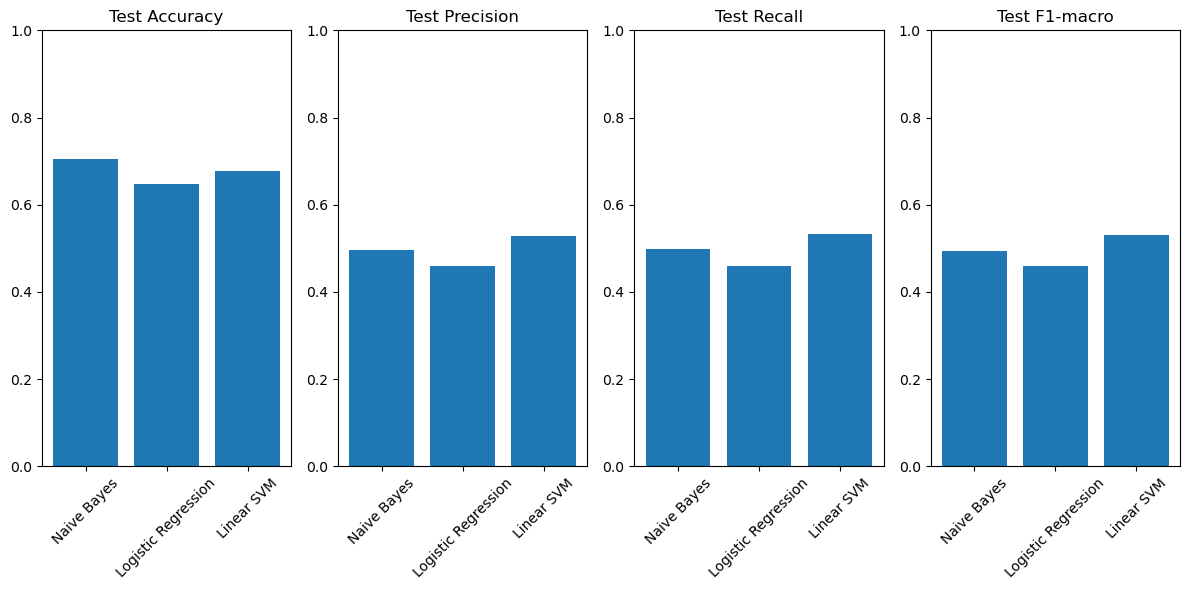

In [42]:
import matplotlib.pyplot as plt

# Plot performance comparison
metrics = ["Test Accuracy", "Test Precision", "Test Recall", "Test F1-macro"]

plt.figure(figsize=(12,6))

for i, metric in enumerate(metrics, 1):
    plt.subplot(1, len(metrics), i)
    plt.bar(results_df["Model"], results_df[metric])
    plt.title(metric, fontsize=12)
    plt.xticks(rotation=45)
    plt.ylim(0, 1)  # since metrics are between 0 and 1

plt.tight_layout()
plt.show()


In [44]:
# We can see that accuracy is pretty high for all models, which is misleading!
# because we can see that F1 Macro (recall & precision) are much lower.
# This happened becuase our dataset is pretty small, and significantly imbalanced. 
# we showed in cells above that the numbers of movies directed by men are almost 4 times more than women! which creates a huge imbalance in our data.
# for further improvements, we can use some methods such as oversampling to fix the problem with imbalanced data!
# but with the current situation, we can see though Naive Bayes showed slightly higher accuracy, 
# Linear SVM showed better F1 score than the other models, which is more desirable for us! so here, Linear SVM wins!